In [1]:
%load_ext autoreload
%autoreload 2

import torch
import transformers
import yaml
from src.utils import utils
from src.model import llama
from transformers import LlamaForCausalLM as OrigLlama
import os
from src import data
import tqdm 
import torch


In [2]:
# !export CUDA_VISIBLE_DEVICES=0,1
# !export CUDA_LAUNCH_BLOCKING=1
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# torch.distributed.init_process_group(backend='nccl')

In [3]:
#config
ft_n_train = 32
ft_n_val = 32
ft_dataset = "pajama"
base_model = "meta-llama/Llama-2-7b-hf"
seqlen = 4096
batch_size = 1
per_device_train_batch_size = 2
use_embedding = False
cache_logits_path = f"temp/cache_logits_{ft_n_train}_{ft_n_val}.pt"

In [4]:
orig_model = OrigLlama.from_pretrained(base_model,
                                       device_map="auto", torch_dtype=torch.float32)



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
overall_data:list[torch.FloatTensor] = data.get_loaders(ft_dataset, nsamples = ft_n_train+ft_n_val
                                  , model = base_model, train_test = "train",
                                  seqlen=seqlen)

overall_data = torch.stack([_[0][0] for _ in overall_data])

Loading Red Pajama: 100%|██████████| 64/64 [00:04<00:00, 14.35it/s]


In [6]:
print(ft_n_train+ft_n_val)

64


In [7]:
@torch.no_grad()
def calculate_logits(model: llama.LlamaForCausalLM, devset, batch_size):
    logits = []
    for i in tqdm.tqdm(range(len(devset) // batch_size), desc = "Calculating logits"):
        logits.append(
            model(devset[i * batch_size:(i + 1) *
                         batch_size].cuda())['logits'].cpu())
    logits = torch.concat(logits, dim=0)
    return logits

overall_out = calculate_logits(orig_model,overall_data, 8)

Calculating logits:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating logits: 100%|██████████| 8/8 [03:40<00:00, 27.56s/it]


In [8]:
# if os.path.exists(cache_logits_path):
#     overall_out = torch.load(cache_logits_path)
# else:
#     overall_out = calculate_logits(orig_model,overall_data, batch_size)
#     torch.save(overall_out, cache_logits_path)

In [9]:
overall_out.shape

torch.Size([64, 4096, 32000])

In [10]:
overall_out = overall_out[:, :-1].contiguous().softmax(dim=-1).float()

In [11]:

del orig_model

In [12]:
from src.utils import utils



utils.clean()

In [13]:
model = llama.LlamaForCausalLM.from_pretrained("/data/lliu/huffman/models/meta-llama/Llama-2-7b-hf/compressed_hf/run_38",
                                               device_map="auto",
                                                  torch_dtype=torch.float32,
                                                    low_cpu_mem_usage=True)

# model = model_utils.get_llama("meta-llama/Llama-2-7b-hf",
#                                device_map="auto",
#                                 dtype=torch.float32)
                          
    

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [14]:
with torch.no_grad():
    non_trained_outs = model(overall_data[[5]].cuda())

In [15]:
overall_out[[0]].shape

torch.Size([1, 4095, 32000])

In [16]:
non_trained_outs.logits.shape

torch.Size([1, 4096, 32000])

In [17]:
#custom kld loss
def custom_kld_loss(outputs, labels, num_items_in_batch):
    # print(outputs['logits'].shape)
    logits = outputs['logits'][:,:-1,:].contiguous()
    # print(logits.shape, labels.shape, num_items_in_batch)
    
    #take the cross entropy loss along the last dimension
    #labels are of the same shape as logits
    loss = -torch.sum(labels * torch.log_softmax(logits, dim=-1), dim=-1)
    loss = loss.mean()
    return loss

custom_kld_loss(non_trained_outs, overall_out[[5]].cuda(), 1)

tensor(2.0019, device='cuda:0')

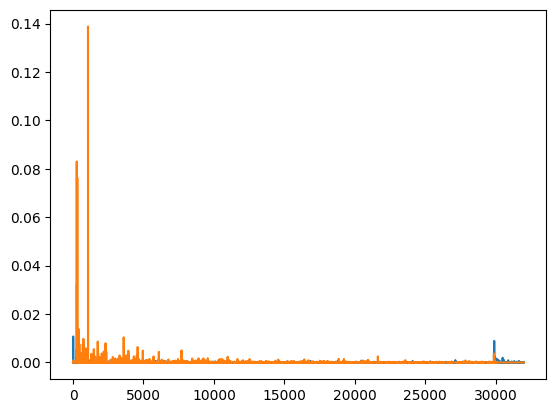

In [18]:
import matplotlib.pyplot as plt

plt.plot(non_trained_outs.logits[0,0].softmax(dim=-1).cpu().numpy())
plt.plot(overall_out[[5]][0,0].cpu().numpy())

In [19]:
overall_out

tensor([[[3.4956e-09, 2.1544e-07, 1.7170e-04,  ..., 5.3435e-08,
          2.1543e-08, 3.1212e-08],
         [1.4783e-10, 6.7904e-10, 2.7640e-04,  ..., 2.5269e-08,
          2.6011e-09, 1.1490e-09],
         [5.7693e-11, 1.8938e-11, 3.6656e-05,  ..., 3.5489e-08,
          3.3033e-09, 4.3084e-09],
         ...,
         [3.5009e-11, 1.2523e-11, 6.4294e-07,  ..., 2.0790e-10,
          7.9399e-10, 3.7515e-11],
         [5.5030e-11, 4.9690e-12, 4.8365e-07,  ..., 3.0510e-10,
          1.3140e-09, 2.7364e-09],
         [3.4451e-11, 4.7730e-12, 1.5994e-06,  ..., 3.4431e-10,
          1.4308e-10, 1.8620e-09]],

        [[2.5547e-10, 5.6940e-07, 6.2397e-04,  ..., 1.1917e-06,
          4.8243e-08, 4.6965e-07],
         [4.7125e-09, 2.0675e-08, 7.5365e-05,  ..., 3.3496e-07,
          6.5462e-08, 2.4501e-06],
         [7.7880e-09, 1.3783e-08, 3.8610e-05,  ..., 1.2072e-06,
          7.2169e-07, 8.2109e-06],
         ...,
         [2.7569e-11, 8.4196e-12, 4.6826e-07,  ..., 1.5128e-09,
          5.327

In [20]:
from torch.utils.data import Dataset
from typing import Tuple
import torch.nn as nn

class SimpleDataset(Dataset):

    def __init__(self, inputs, soft_labels):
        self.inputs = inputs
        self.soft_labels = soft_labels
    

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return {
            'input_ids': self.inputs[idx],
            'labels': self.soft_labels[idx],
        }
    
def make_datasets(X:torch.FloatTensor, Y:torch.FloatTensor, n_val:int) -> Tuple[Dataset, Dataset]:
    

    #make the indices
    idxs = torch.randperm(len(X))
    train_idxs = idxs[:-n_val]

    train_ds = SimpleDataset(X[train_idxs], Y[train_idxs])
    valid_ds = SimpleDataset(X[idxs[-n_val:]], Y[idxs[-n_val:]])
    return train_ds, valid_ds

traindataset, validdataset = make_datasets(overall_data, overall_out, ft_n_val)

In [21]:
print(ft_n_val)

32


In [22]:
print(len(overall_data))

64


In [23]:
len(traindataset), len(validdataset)

(32, 32)

In [25]:
#train the model on the dataset with transformers trainer

trainer = transformers.Trainer(
    model=model,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=per_device_train_batch_size,
        gradient_accumulation_steps=4,
        gradient_checkpointing=True,
        fp16=True,
        logging_steps=1,
        output_dir="./output",
        num_train_epochs=10,
        save_total_limit=3,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        # eval_steps=100,
        # per_device_train_batch_size=32,
        load_best_model_at_end=True,
        #add a tqdm progress bar
        #set the lr to 1e-5
        learning_rate=1e-6,
        #constat lr
        lr_scheduler_type="constant",
        # warmup_steps=100,
        dataloader_pin_memory=True,
        #set the logging dir to ./logs
        logging_dir="./logs",
        #log to wandb
        report_to="wandb",
        run_name="llama-2-7b-hf-soft",
        eval_on_start = True,
    ),
    train_dataset=traindataset,
    eval_dataset=validdataset,
    compute_loss_func=custom_kld_loss,
)

trainer.train()



/home/lliu/miniconda3/envs/NoWAC-VQ/lib/python3.13/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: m6481 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
0,No log,1.736315
1,6.844500,1.732244
2,7.786100,1.727216


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


KeyboardInterrupt: 